# Adversarial Robustness Tutorial

In this tutorial, we will:

- Implement and run adversarial attacks on a standard neural network.
- Build and train a Lipschitz-constrained network (LipNet).
- Evaluate the empirical and certified robustness of the LipNet.

**Table of contents**

1. [🧠 Train a standard neural network on MNIST](#train-mnist)
2. [⚔️ Adversarial attacks](#️adv-att)
3. [🛡️ Robustness with Lipschitz-constrained networks](#lipschitz)


**Package Requirements**

This notebook requires the following packages:

`notebook`, `torch`, `torchvision`, `torchattacks`, `deel-torchlip`, `matplotlib`

You can run the following command to install the requirements:

```bash
pip install -r requirements.txt
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## 1. 🧠 Train a standard neural network on MNIST <a id="train-mnist"></a>

In this first section, we will train a very simple CNN on MNIST. There is no exercice
here.

In [3]:
# Device & Hyperparameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

BATCH_SIZE = 128
VAL_SPLIT = 0.1
NUM_EPOCHS = 10
LR = 1e-3

Using device: cuda


### 1.1 Load MNIST dataset

We will:

- Use the **MNIST** dataset (handwritten digits 0–9).
- Split the original training set into:
  - a **train** set
  - a small **validation** set (to monitor training)

We also create a **test** loader to evaluate the final model.

In [4]:
# Dataloaders for MNIST
def get_mnist_dataloaders(batch_size=BATCH_SIZE, val_split=VAL_SPLIT):
    transform = transforms.Compose([transforms.ToTensor()])

    trainval_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

    n_total = len(trainval_dataset)
    n_val = int(n_total * val_split)
    n_train = n_total - n_val

    train_dataset, val_dataset = random_split(trainval_dataset, [n_train, n_val])

    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, val_loader, test_loader


train_loader, val_loader, test_loader = get_mnist_dataloaders()

### 1.2 Build a simple CNN network

We define a very small convolutional neural network:

- Two convolutional layers with ReLU and max pooling.
- Two fully connected layers.

This is not a state-of-the-art model, but it is good enough to reach high accuracy on
MNIST and to demonstrate adversarial attacks.


In [5]:
# Small CNN Model


class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 1x28x28 -> 32x28x28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 32x14x14 -> 64x14x14
        self.pool = nn.MaxPool2d(2, 2)  # downsample by 2
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> 32 x 14 x 14
        x = self.pool(F.relu(self.conv2(x)))  # -> 64 x 7 x 7
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits


model = SimpleCNN().to(device)

### 1.3 Training

We define three helper functions:

- `train_one_epoch` – does one pass over the training data.
- `evaluate` – computes loss and accuracy on a given dataloader.
- `train` – trains on multiple epochs using the two previous helper functions. 

We will train only for a few epochs (e.g., 10 epochs).  
The goal is just to get the model to a reasonable accuracy so that we can see meaningful
adversarial examples.


In [6]:
# Training & Evaluation helper functions


def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def train(model, train_loader, val_loader, optimizer, criterion, device):
    print("Starting training...")
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        print(
            f"Epoch [{epoch + 1}/{NUM_EPOCHS}] "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
            f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

In [7]:
# Train the standard model

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train(model, train_loader, val_loader, optimizer, criterion, device)

Starting training...
Epoch [1/10] Train Loss: 0.2394, Train Acc: 0.9271 | Val Loss: 0.0859, Val Acc: 0.9742
Epoch [2/10] Train Loss: 0.0617, Train Acc: 0.9806 | Val Loss: 0.0540, Val Acc: 0.9837
Epoch [3/10] Train Loss: 0.0439, Train Acc: 0.9862 | Val Loss: 0.0516, Val Acc: 0.9850
Epoch [4/10] Train Loss: 0.0326, Train Acc: 0.9901 | Val Loss: 0.0548, Val Acc: 0.9842
Epoch [5/10] Train Loss: 0.0253, Train Acc: 0.9917 | Val Loss: 0.0411, Val Acc: 0.9882
Epoch [6/10] Train Loss: 0.0182, Train Acc: 0.9938 | Val Loss: 0.0403, Val Acc: 0.9895
Epoch [7/10] Train Loss: 0.0150, Train Acc: 0.9952 | Val Loss: 0.0374, Val Acc: 0.9897
Epoch [8/10] Train Loss: 0.0132, Train Acc: 0.9957 | Val Loss: 0.0489, Val Acc: 0.9877
Epoch [9/10] Train Loss: 0.0107, Train Acc: 0.9963 | Val Loss: 0.0413, Val Acc: 0.9895
Epoch [10/10] Train Loss: 0.0090, Train Acc: 0.9969 | Val Loss: 0.0425, Val Acc: 0.9900


### 1.4 Evaluate on Test Set

We now measure how well the trained model performs on unseen test images.
We expect a high accuracy (above 98% usually), but the exact number is not critical.


In [8]:
# Test Evaluation
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test Loss: 0.0338, Test Acc: 0.9900


### 1.5 Visualizing Logits for One Image

The model outputs **logits**: raw scores for each class (0–9).  
We will visualize these logits by sorting them in descending order.

This helps us see how "confident" the model is for each class. We will see later that
for Lipschitz-constrained networks, these logits are keys to guarantee the robustness
of the model.


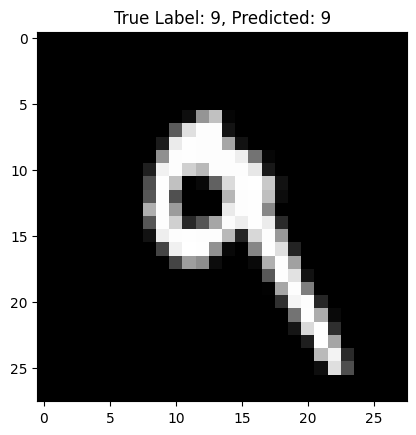

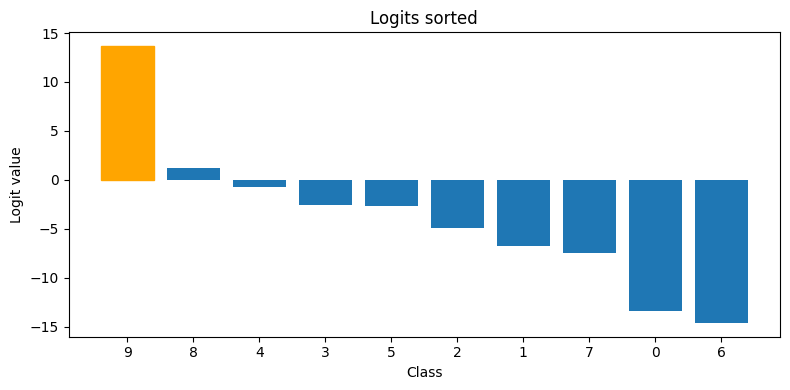

In [9]:
# Plot logits (sorted) with top-1 prediction highlighted

MNIST_CLASS_NAMES = [str(i) for i in range(10)]


def plot_sorted_logits(logits: torch.Tensor, class_names=MNIST_CLASS_NAMES, use_softmax=False):
    """
    logits: 1D tensor of shape (num_classes,)
    Plots logits sorted by value (descending) with class names on x-axis.
    Top-1 predicted class is the first bar.
    """
    if logits.dim() != 1:
        raise ValueError("logits must be a 1D tensor for a single sample.")

    logits = logits.detach().cpu()
    if use_softmax:
        logits = F.softmax(logits, dim=0)
    sorted_indices = torch.argsort(logits, descending=True)
    sorted_logits = logits[sorted_indices]

    labels = [class_names[i] for i in sorted_indices]

    plt.figure(figsize=(8, 4))
    bars = plt.bar(range(len(sorted_logits)), sorted_logits)

    # Optionally highlight the top-1 bar
    bars[0].set_color("orange")

    plt.xticks(range(len(sorted_logits)), labels)
    plt.xlabel("Class")
    plt.ylabel("Logit value")
    plt.title("Logits sorted" + (" (Softmax)" if use_softmax else ""))
    plt.tight_layout()
    plt.show()


model.eval()
with torch.no_grad():
    sample_images, sample_labels = next(iter(test_loader))
    sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)
    sample_logits = model(sample_images)

# Plot single image
idx = 7
plt.imshow(sample_images[idx].cpu().squeeze(), cmap="gray")
plt.title(f"True Label: {sample_labels[idx].item()}, Predicted: {sample_logits[idx].argmax().item()}")

# Plot sorted logits on one test sample
plot_sorted_logits(sample_logits[idx], MNIST_CLASS_NAMES)

### 1.6 Compute the Lipshitz constant of some layers

Computing the global Lipschitz constant of a network is known to be NP-hard. But the
Lipschitz constant of the linear layers (fully connected layers and convolutions) can be
computed and give an approximate idea of the global Lipschitz constant.

Remember that the global Lipschitz constant $L_f$ is upper-bounded by the product of all
layer's Lipschitz constants $L_i$:

$$ L_f \leq \prod_i L_i$$

In the following code cells, we compute the Lipschitz constants of the two linear layers
and the two convolutions. The computation for the convolutions is quite time-consuming,
because we build the entire Toeplitz matrix corresponding to the linear operation.

In [10]:
# For the two last linear layers of the model, compute the spectral norm of their weight matrices
def compute_spectral_norm(layer: nn.Linear):
    weight = layer.weight.data
    u, s, v = torch.svd(weight)
    return s[0].item()


spectral_norm_fc1 = compute_spectral_norm(model.fc1)
spectral_norm_fc2 = compute_spectral_norm(model.fc2)

print(f"Spectral Norm of fc1: {spectral_norm_fc1:.4f}")
print(f"Spectral Norm of fc2: {spectral_norm_fc2:.4f}")

Spectral Norm of fc1: 7.8696
Spectral Norm of fc2: 1.2963


In [11]:
# Build the Toeplitz matrix for the convolutional layers


def conv2d_toeplitz(conv_layer: nn.Conv2d, input_size=(1, 28, 28)):
    in_channels = conv_layer.in_channels
    out_channels = conv_layer.out_channels
    kernel_size = conv_layer.kernel_size
    stride = conv_layer.stride
    padding = conv_layer.padding

    H_in, W_in = input_size[1], input_size[2]
    H_out = (H_in + 2 * padding[0] - kernel_size[0]) // stride[0] + 1
    W_out = (W_in + 2 * padding[1] - kernel_size[1]) // stride[1] + 1

    toeplitz_matrix = torch.zeros((out_channels * H_out * W_out, in_channels * H_in * W_in))

    for out_c in range(out_channels):
        for in_c in range(in_channels):
            kernel = conv_layer.weight.data[out_c, in_c]
            for i in range(H_out):
                for j in range(W_out):
                    row = out_c * H_out * W_out + i * W_out + j
                    for ki in range(kernel_size[0]):
                        for kj in range(kernel_size[1]):
                            ii = i * stride[0] + ki - padding[0]
                            jj = j * stride[1] + kj - padding[1]
                            if 0 <= ii < H_in and 0 <= jj < W_in:
                                col = in_c * H_in * W_in + ii * W_in + jj
                                toeplitz_matrix[row, col] = kernel[ki, kj]

    return toeplitz_matrix


# Compute spectral norm of the Toeplitz matrix
print("Computing spectral norms of convolutional layers via Toeplitz matrices...")
toeplitz_conv1 = conv2d_toeplitz(model.conv1, input_size=(1, 28, 28))
toeplitz_conv2 = conv2d_toeplitz(model.conv2, input_size=(32, 14, 14))

print("Computing SVD for Toeplitz matrix...")
u, s, v = torch.svd(toeplitz_conv1)
spectral_norm_conv1 = s[0].item()
u, s, v = torch.svd(toeplitz_conv2)
spectral_norm_conv2 = s[0].item()

print(f"Spectral Norm of conv1 (Toeplitz): {spectral_norm_conv1:.4f}")
print(f"Spectral Norm of conv2 (Toeplitz): {spectral_norm_conv2:.4f}")

Computing spectral norms of convolutional layers via Toeplitz matrices...
Computing SVD for Toeplitz matrix...
Spectral Norm of conv1 (Toeplitz): 6.2685
Spectral Norm of conv2 (Toeplitz): 11.0051


In [12]:
# Upper bound of the global Lipschitz constant

lipschitz_bound = spectral_norm_conv1 * spectral_norm_conv2 * spectral_norm_fc1 * spectral_norm_fc2
print(f"Upper bound of the global Lipschitz constant: {lipschitz_bound:.4f}")

Upper bound of the global Lipschitz constant: 703.7175


## 2. ⚔️ Adversarial attacks <a id="adv-att"></a>

An adversarial attack in classification is the process of finding an image $x_{adv}$
close to the original image $x$ such that the predicted class is different, i.e.
$f(x_{adv})$ and $f(x)$ differs. It was shown that it is easy to build such an
adversarial example on standard neural networks even with a very small added noise. In
the following, we suppose that the original image is correctly classified, i.e. the
attack tries to predict a class different from the true label.

Related to the sorted logits plot above, the idea is to find a small perturbation on the
input in order to change the highest logit. 

In the following, we will:
1. Implement and run the simple FGM method, in the untargeted setup.
2. Implement and run the same attack but with a targeted objective.
3. Use a more sophisticated attack with the `torchattacks` library.

### 2.1 Untargeted FGM attack

Here, we want to implement the untargeted FGM attack, defined as:

$$x_{adv} = x + \epsilon \frac{\nabla_{x} l(f_\theta(x), y)}{\| \nabla_{x}
l(f_\theta(x), y) \|}.$$

$\epsilon$ defines the budget of the attack and controls how strong the attack is. Note
that the distance between $x_{adv}$ and $x$ (in $\ell_2$ norm) is $\epsilon$. The FGM
attack simply goes in the direction of the gradient to increase the loss for the true
label. It is highly related to the L2-PGD attack with a single iteration.

**Exercise 2.1.1**

Complete the following code for the untargeted FGM attack.

In [13]:
# Implement the untargeted FGM Attack


def fgm_attack_untargeted(model, images, labels, epsilon, loss_fn=None):
    """
    Untargeted FGM.

    Args:
        images: (N, C, H, W) tensor, normalized as in training
        labels: (N,) tensor for true labels
        epsilon: attack budget (same space as normalized images)
        loss_fn: loss function to maximize (default: CrossEntropyLoss)

    Returns:
        adv_images: (N, C, H, W) tensor of FGM adversarial samples
    """

    model.eval()
    loss_fn = loss_fn or nn.CrossEntropyLoss()

    images = images.clone().detach().to(device)
    labels = labels.to(device)
    images.requires_grad = True

    outputs = model(images)
    loss = loss_fn(outputs, labels)

    model.zero_grad()
    loss.backward()

    grad_norm = torch.norm(images.grad.view(images.size(0), -1), dim=1).view(-1, 1, 1, 1)
    adv_images = images + epsilon * images.grad / grad_norm

    adv_images = torch.clamp(adv_images, 0, 1)

    return adv_images.detach()

In [14]:
# Run FGM attack on the first batch

images, labels = next(iter(test_loader))
adv_images_untargeted = fgm_attack_untargeted(model, images, labels, epsilon=1.5)

In [15]:
def plot_adversarial_examples(model, original, adversarial):
    """
    Displays the original and adversarial images, and their difference.

    Args:
        model: the trained model (used to get predictions)
        original: (1, H, W) tensor
        adversarial: (1, H, W) tensor
    """

    # Get prediction of original and adversarial
    model.eval()
    with torch.no_grad():
        orig_pred = model(original.unsqueeze(0).to(device)).argmax(dim=1).item()
        adv_pred = model(adversarial.unsqueeze(0).to(device)).argmax(dim=1).item()

    original = original.cpu().squeeze()  # (1, H, W) -> (H, W)
    adversarial = adversarial.cpu().squeeze()  # (1, H, W) -> (H, W)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title(f"Original Image (pred: {orig_pred})")
    plt.imshow(original, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title(f"Adversarial Image (pred: {adv_pred})")
    plt.imshow(adversarial, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    diff_norm = torch.norm(adversarial - original)
    plt.title(f"Difference (epsilon={diff_norm:.2f})")
    diff_pos = F.relu(adversarial - original)
    diff_neg = F.relu(original - adversarial)
    difference = torch.stack([diff_neg, diff_pos, torch.zeros_like(diff_pos)], dim=-1)
    difference /= difference.abs().max()
    plt.imshow(difference, cmap="gray")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

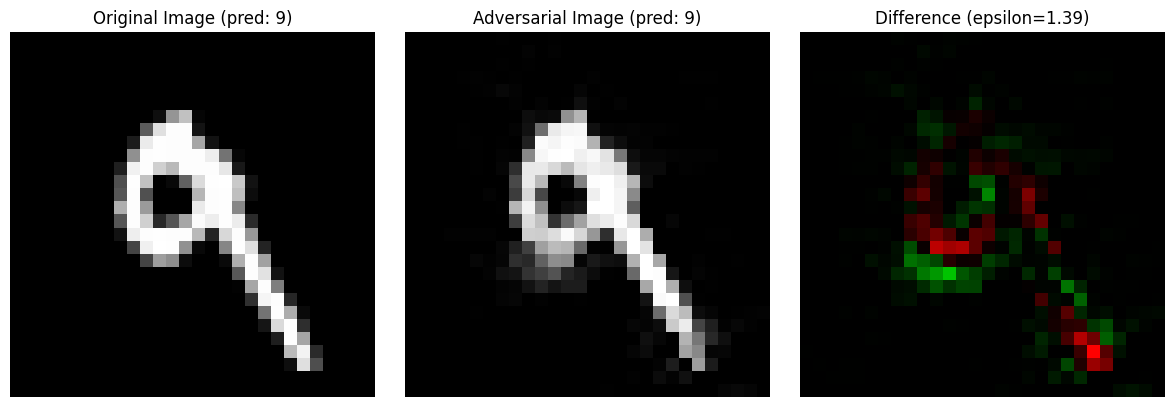

In [16]:
# Plot the original and adversarial images

idx = 7
plot_adversarial_examples(model, images[idx], adv_images_untargeted[idx])

Original Image Logits:


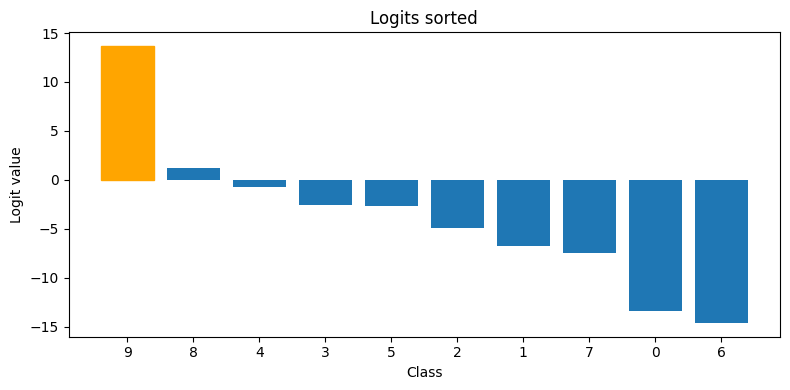

Adversarial Image Logits:


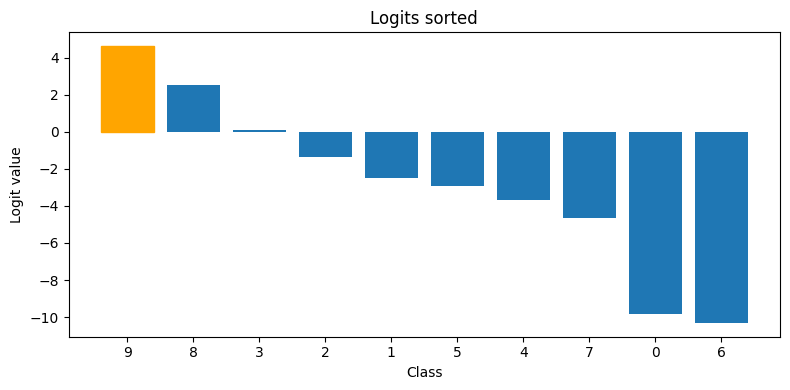

In [17]:
# Plot the sorted logits for original and adversarial images

print("Original Image Logits:")
plot_sorted_logits(model(images[idx].unsqueeze(0).to(device)).squeeze(), MNIST_CLASS_NAMES)
print("Adversarial Image Logits:")
plot_sorted_logits(model(adv_images_untargeted[idx].unsqueeze(0).to(device)).squeeze(), MNIST_CLASS_NAMES)

**Exercise 2.1.2**

We want to find (approximately) the minimum budget $\epsilon$ to change the original
class. We will perform successive attacks with different values of $\epsilon$ and find
when the attack succeeds.

In [18]:
# Change epsilon budget to observe when the attack becomes successful

epsilons = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

for eps in epsilons:
    adv_images_untargeted = fgm_attack_untargeted(model, images, labels, epsilon=eps)

    adv_preds = model(adv_images_untargeted.to(device)).argmax(dim=1)
    diffs = torch.norm(images[idx].to(device) - adv_images_untargeted[idx])

    if adv_preds[idx].item() != labels[idx].item():
        print(f"✅ Attack succeeded at epsilon = {diffs:.4f}  (set budget = {eps})")
    else:
        print(f"❌ Attack failed at epsilon = {diffs:.4f}  (set budget = {eps})")

❌ Attack failed at epsilon = 0.9334  (set budget = 1.0)
❌ Attack failed at epsilon = 1.0246  (set budget = 1.1)
❌ Attack failed at epsilon = 1.1155  (set budget = 1.2)
❌ Attack failed at epsilon = 1.2063  (set budget = 1.3)
❌ Attack failed at epsilon = 1.2961  (set budget = 1.4)
❌ Attack failed at epsilon = 1.3850  (set budget = 1.5)
❌ Attack failed at epsilon = 1.4741  (set budget = 1.6)
❌ Attack failed at epsilon = 1.5619  (set budget = 1.7)
❌ Attack failed at epsilon = 1.6492  (set budget = 1.8)
❌ Attack failed at epsilon = 1.7363  (set budget = 1.9)
✅ Attack succeeded at epsilon = 1.8221  (set budget = 2.0)


### 2.2 Targeted FGM attack

Previously, the untargeted attack aims at changing the predicted class, whatever the new
prediction. In the targeted setting, we want to attack towards a specific class.
Depending on the target, this attack can require more budget to succeed.

The targeted adversarial sample $x_{adv}$ is:

$$x_{adv} = x - \epsilon \frac{\nabla_{x} l(f_\theta(x), y^t)}{\| \nabla_{x}
l(f_\theta(x), y^t) \|}$$

with $y^t$ being the targeted class. Note the **minus sign**: we are moving the input in
the direction that makes the model more confident in the target class, i.e minimizing
the loss considering the target class.

**Exercise 2.2.1**

Implement the targeted FGM attack.

In [19]:
# Targeted FGM Attack


def fgm_attack_targeted(model, images, target_labels, epsilon, loss_fn=None):
    """
    Targeted FGM

    Args:
        images: (N, C, H, W) tensor, normalized as in training
        target_labels: (N,) tensor of desired target classes
        epsilon: attack budget (same space as normalized images)
        loss_fn: loss function to minimize (default: CrossEntropyLoss)

    Returns:
        adv_images: (N, C, H, W) tensor of targeted FGM adversarial samples
    """
    model.eval()
    loss_fn = loss_fn or nn.CrossEntropyLoss()

    images = images.clone().detach().to(device)
    target_labels = target_labels.to(device)
    images.requires_grad = True

    outputs = model(images)
    loss = loss_fn(outputs, target_labels)

    model.zero_grad()
    loss.backward()

    grad_norm = torch.norm(images.grad.view(images.size(0), -1), dim=1).view(-1, 1, 1, 1)
    adv_images = images - epsilon * images.grad / grad_norm

    adv_images = torch.clamp(adv_images, 0, 1)

    return adv_images.detach()

In [20]:
# Run targeted FGM attack

images, labels = next(iter(test_loader))
target_labels = torch.ones_like(labels) * 2  # targets all set to class '2'
adv_images_targeted = fgm_attack_targeted(model, images, target_labels, epsilon=3.0)

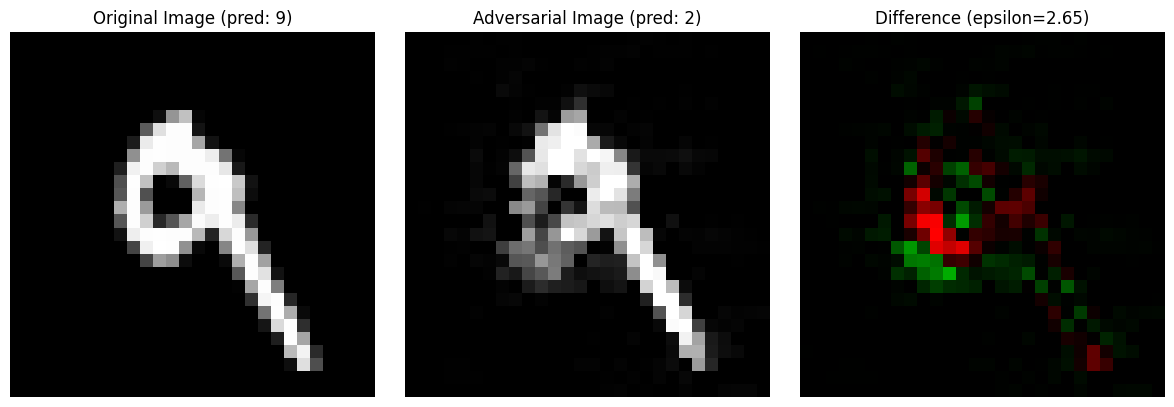

In [21]:
# Plot the original and targeted adversarial images

idx = 7
plot_adversarial_examples(model, images[idx], adv_images_targeted[idx])

Original Image Logits:


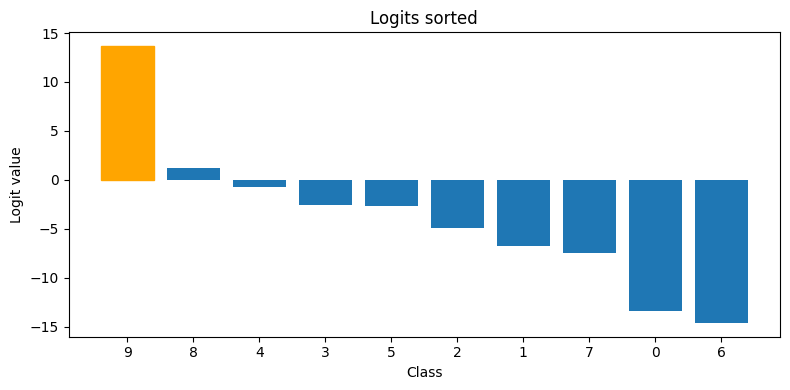

Targeted Adversarial Image Logits:


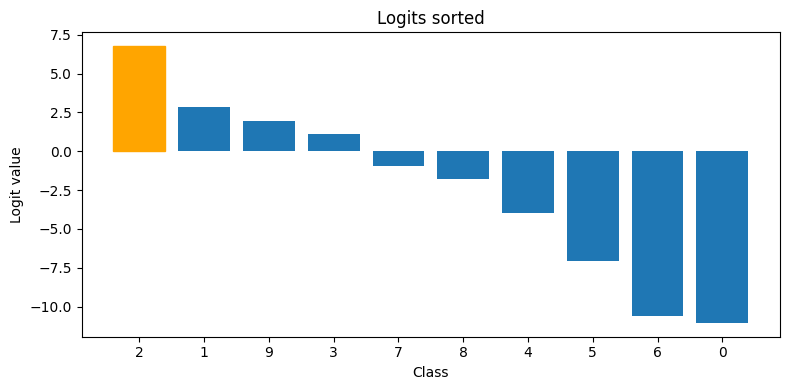

In [22]:
# Plot the sorted logits for original and adversarial images

print("Original Image Logits:")
plot_sorted_logits(model(images[idx].unsqueeze(0).to(device)).squeeze(), MNIST_CLASS_NAMES)
print("Targeted Adversarial Image Logits:")
plot_sorted_logits(model(adv_images_targeted[idx].unsqueeze(0).to(device)).squeeze(), MNIST_CLASS_NAMES)

### 2.3 Run more complex attacks

The FGM attack implemented above is a very simple way to find an adversarial example.
Many attacks exist and perform much better than FGM, e.g. PGD, Carlini&Wagner,
Auto-Attack, etc.

There are several Python libraries to run adversarial attacks: 

- [ART toolbox](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/)
- [foolbox](https://foolbox.jonasrauber.de/)
- [Adversarial Library](https://github.com/jeromerony/adversarial-library)
- [Torchattacks](https://github.com/Harry24k/adversarial-attacks-pytorch)


We will use the `torchattacks` library that implements several well-known attacks.


**Exercise 2.3.1**

Run APGD attack on the first batch of test images. Be careful with `torchattacks`: if
the attack fails and no adversarial image is found within the budget, `torchattacks`
returns the original image (instead of an adversarial one).


In [23]:
# Run APGD with torchattacks

from torchattacks import APGD

apgd_attack = APGD(
    model,
    norm="L2",
    eps=1.3,
    n_restarts=5,
    verbose=True,
)

images, labels = next(iter(test_loader))
adv_images_apgd = apgd_attack(images, labels)
adv_images_apgd = adv_images_apgd.detach().cpu()

-------------------------- running L2-attack with epsilon 1.3000 --------------------------
initial accuracy: 100.00%
parameters:  10 2 1 1
iteration: 0 - Best loss: 1.184719
iteration: 1 - Best loss: 61.179337
iteration: 2 - Best loss: 133.537537
iteration: 3 - Best loss: 153.849411
iteration: 4 - Best loss: 154.917236
iteration: 5 - Best loss: 155.927979
iteration: 6 - Best loss: 157.201706
iteration: 7 - Best loss: 160.965286
iteration: 8 - Best loss: 163.790985
iteration: 9 - Best loss: 165.950531
restart 0 - robust accuracy: 66.41% - cum. time: 0.3 s
parameters:  10 2 1 1
iteration: 0 - Best loss: 0.001495
iteration: 1 - Best loss: 0.516183
iteration: 2 - Best loss: 3.515664
iteration: 3 - Best loss: 5.943321
iteration: 4 - Best loss: 6.291430
iteration: 5 - Best loss: 6.463271
iteration: 6 - Best loss: 6.709867
iteration: 7 - Best loss: 7.247525
iteration: 8 - Best loss: 7.685590
iteration: 9 - Best loss: 7.996689
restart 1 - robust accuracy: 66.41% - cum. time: 0.4 s
parameters:

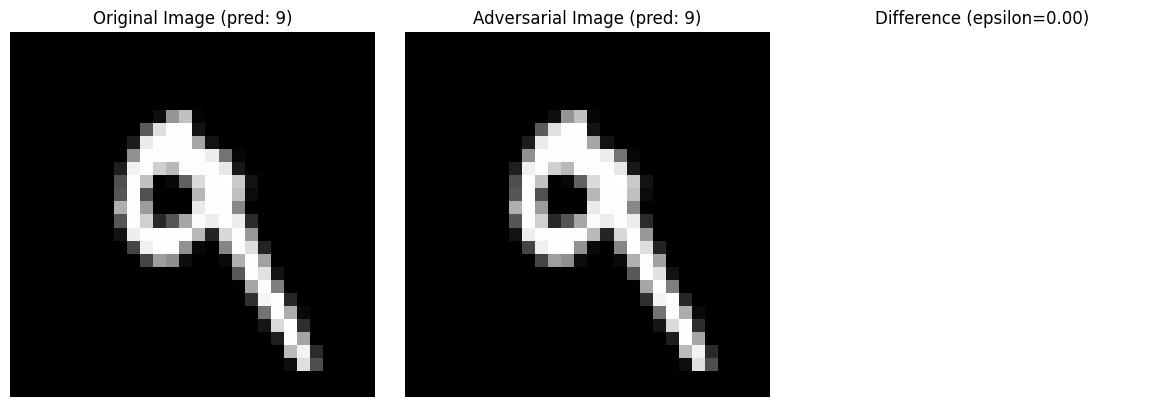

In [24]:
idx = 7
plot_adversarial_examples(model, images[idx], adv_images_apgd[idx])

**Exercise 2.3.2**

Compare performance with the FGM attack. Which attack performs best? 

In [25]:
# Comparison between FGM and APGD

for eps in [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]:
    apgd_attack = APGD(
        model,
        norm="L2",
        eps=eps,
        n_restarts=5,
        verbose=False,
    )

    images, labels = next(iter(test_loader))
    adv_images_apgd = apgd_attack(images, labels)
    adv_images_apgd = adv_images_apgd.detach().cpu()

    adv_preds = model(adv_images_apgd.to(device)).argmax(dim=1)
    diffs = torch.norm(images[idx] - adv_images_apgd[idx])

    if adv_preds[idx].item() != labels[idx].item():
        print(f"✅ Attack succeeded at epsilon = {diffs:.4f}  (set budget = {eps})")
    else:
        print(f"❌ Attack failed at epsilon = {eps:.4f}  (set budget = {eps})")

❌ Attack failed at epsilon = 1.0000  (set budget = 1.0)
❌ Attack failed at epsilon = 1.1000  (set budget = 1.1)
❌ Attack failed at epsilon = 1.2000  (set budget = 1.2)
❌ Attack failed at epsilon = 1.3000  (set budget = 1.3)
✅ Attack succeeded at epsilon = 1.3805  (set budget = 1.4)
✅ Attack succeeded at epsilon = 1.4779  (set budget = 1.5)
✅ Attack succeeded at epsilon = 1.5791  (set budget = 1.6)
✅ Attack succeeded at epsilon = 1.6628  (set budget = 1.7)
✅ Attack succeeded at epsilon = 1.7484  (set budget = 1.8)
✅ Attack succeeded at epsilon = 1.8126  (set budget = 1.9)
✅ Attack succeeded at epsilon = 1.9431  (set budget = 2.0)


To go further, you can try other attacks, like AutoAttack which is a combination of
state-of-the-art attacks. AutoAttack performs very well but is costly due to the
evaluations of multiple attacks.

## 3. 🛡️ Robustness with Lipschitz-constrained networks <a id="lipschitz"></a>

In this last section, we will see how Lipschitz-constrained networks can be used to
be robust to adversarial attacks and to certify the robustness.

### 3.1 Build and train a Lipschitz-constrained network

First, we will build and train a simple Lipschitz-constrained network, with the same
architecture as the unconstrained network above.

Recall that the loss is the keystone of the accuracy/robustness trade-off. The
hyperparameter allows to tune the robustness of the model. Here, using the
Tau-Cross-Entropy loss, the model is more robust for small temperatures `tau`.


**Exercise 3.1.1**

Build a LipNet using the `torchlip` layers.

In [26]:
# Small Lipschitz CNN Model

from deel.torchlip import SpectralConv2d, SpectralLinear, ScaledL2NormPool2d, GroupSort2


class LipCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = SpectralConv2d(1, 32, kernel_size=3, padding="same")
        self.conv2 = SpectralConv2d(32, 64, kernel_size=3, padding="same")
        self.pool = ScaledL2NormPool2d(2, 2)
        self.fc1 = SpectralLinear(64 * 7 * 7, 128)
        self.fc2 = SpectralLinear(128, num_classes)
        self.activation = GroupSort2()

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))  # -> 32 x 14 x 14
        x = self.pool(self.activation(self.conv2(x)))  # -> 64 x 7 x 7
        x = x.view(x.size(0), -1)  # flatten
        x = self.activation(self.fc1(x))
        logits = self.fc2(x)
        return logits


lip_model = LipCNN().to(device)

**Exercise 3.1.2**

Train the LipNet with a Tau-Cross-Entropy. Set the temperature to 10.

In [27]:
# Training LipCNN with Tau-Cross-Entropy Loss

from deel.torchlip import TauCrossEntropyLoss

criterion = TauCrossEntropyLoss(tau=10)
optimizer = torch.optim.Adam(lip_model.parameters(), lr=LR)

train(lip_model, train_loader, val_loader, optimizer, criterion, device)

Starting training...
Epoch [1/10] Train Loss: 0.0220, Train Acc: 0.9346 | Val Loss: 0.0094, Val Acc: 0.9740
Epoch [2/10] Train Loss: 0.0075, Train Acc: 0.9785 | Val Loss: 0.0078, Val Acc: 0.9773
Epoch [3/10] Train Loss: 0.0060, Train Acc: 0.9825 | Val Loss: 0.0064, Val Acc: 0.9803
Epoch [4/10] Train Loss: 0.0050, Train Acc: 0.9856 | Val Loss: 0.0050, Val Acc: 0.9858
Epoch [5/10] Train Loss: 0.0042, Train Acc: 0.9881 | Val Loss: 0.0047, Val Acc: 0.9865
Epoch [6/10] Train Loss: 0.0037, Train Acc: 0.9897 | Val Loss: 0.0051, Val Acc: 0.9862
Epoch [7/10] Train Loss: 0.0034, Train Acc: 0.9906 | Val Loss: 0.0041, Val Acc: 0.9890
Epoch [8/10] Train Loss: 0.0032, Train Acc: 0.9913 | Val Loss: 0.0041, Val Acc: 0.9880
Epoch [9/10] Train Loss: 0.0030, Train Acc: 0.9914 | Val Loss: 0.0044, Val Acc: 0.9863
Epoch [10/10] Train Loss: 0.0027, Train Acc: 0.9930 | Val Loss: 0.0044, Val Acc: 0.9878


In [28]:
# Test Evaluation

test_loss, test_acc = evaluate(lip_model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test Loss: 0.0038, Test Acc: 0.9892


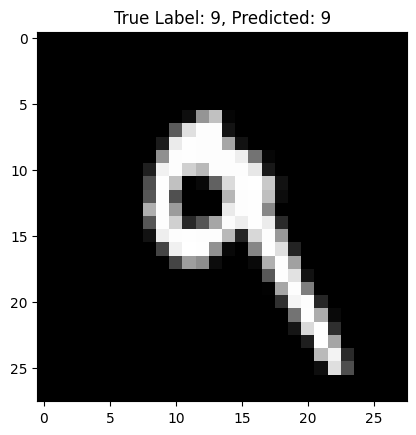

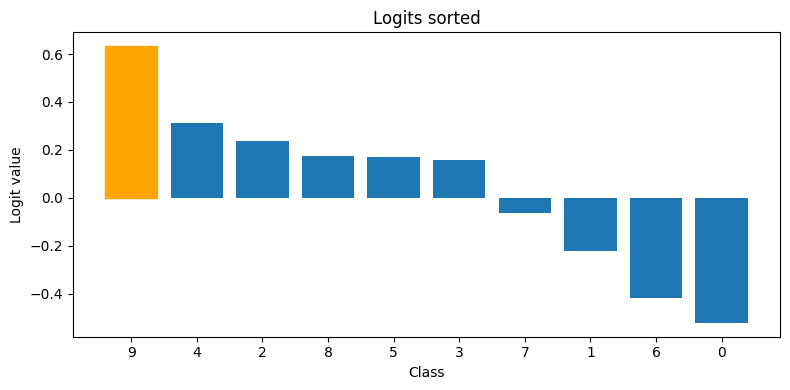

In [29]:
# Plot image and sorted logits for LipCNN

lip_model.eval()
with torch.no_grad():
    sample_images, sample_labels = next(iter(test_loader))
    sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)
    sample_logits = lip_model(sample_images)

# Plot a single image
idx = 7
plt.imshow(sample_images[idx].cpu().squeeze(), cmap="gray")
plt.title(f"True Label: {sample_labels[idx].item()}, Predicted: {sample_logits[idx].argmax().item()}")

# Plot sorted logits
plot_sorted_logits(sample_logits[idx], MNIST_CLASS_NAMES)

### 3.2 Compute robustness certificates

Thanks to the knowledge of the Lipschitz constant, we can guarantee that there is no
attack with a budget lower than the certificate $\mathcal{M}$ that can change the
prediction of the original image $x$. This certificate is defined as:

$$ \mathcal{M}(x) = \frac{f_\theta(x)_{top1} - f_\theta(x)_{top2}}{\sqrt{2}} $$

This certificate is based on the difference between the two highest logits (recall the figure above where we plot the sorted logits).


**Exercise 3.2.1**

Complete the function that builds the certificates.

In [30]:
# Compute Lipschitz Certificates


def compute_certificates(lip_model, images):
    """
    Computes Lipschitz certificates for the given images.

    Args:
        lip_model: the trained Lipschitz model
        images: (N, C, H, W) tensor of input images

    Returns:
        a (N,) tensor of certificates and a (N,) tensor of predicted classes
    """

    lip_model.eval()
    with torch.no_grad():
        logits = lip_model(images.to(device))
        preds = logits.argmax(dim=1)
        sorted_logits, _ = torch.sort(logits, dim=1, descending=True)
        margins = sorted_logits[:, 0] - sorted_logits[:, 1]  # (N,)
        certificates = margins / 2**0.5
    return certificates.cpu(), preds.detach().cpu()

In [31]:
# Compute certificates for a batch of test images

certificates, _ = compute_certificates(lip_model, images)
print("Certificates:\n", certificates)
print("Certificate for image idx =", idx, ":", certificates[idx].item())

Certificates:
 tensor([0.7113, 0.8034, 0.6136, 0.5820, 0.6654, 0.6694, 0.4932, 0.2268, 0.3604,
        0.3526, 0.7819, 0.3516, 0.4033, 0.8018, 0.7194, 0.5155, 0.2950, 0.6259,
        0.0373, 0.6228, 0.1357, 0.3005, 0.4881, 0.7936, 0.4886, 0.4815, 0.6071,
        1.0034, 0.7967, 0.5915, 0.7614, 0.5318, 0.6770, 0.2910, 0.6138, 0.9503,
        0.3659, 0.6904, 0.5228, 0.5886, 0.5809, 0.3945, 0.5813, 0.2851, 0.5595,
        0.5829, 0.4561, 0.8010, 0.5534, 0.8061, 0.6270, 0.8000, 0.6581, 0.5893,
        0.3812, 0.8461, 0.9919, 0.5691, 0.4974, 0.4959, 0.9090, 0.3708, 0.0897,
        0.2423, 0.8566, 0.3757, 0.4904, 0.6504, 0.8966, 0.8814, 0.6036, 0.9885,
        0.8377, 0.1632, 0.6851, 0.7280, 0.5646, 0.6392, 0.2700, 0.6773, 0.5642,
        0.5440, 0.9756, 0.7294, 0.6953, 0.7121, 0.7189, 0.5861, 0.6625, 0.5768,
        0.7084, 0.6710, 0.1009, 0.5629, 0.5501, 0.5330, 0.3469, 0.5174, 0.4760,
        0.5012, 0.4841, 0.9097, 0.6777, 0.8138, 0.2503, 0.4722, 0.8088, 0.5197,
        0.3370, 0.7443, 0

### 3.3 Run adversarial attacks on the LipNet

We can compare the empirical robustness of our LipNet with the unconstrained network.

**Exercise 3.3.1**

Run untargeted FGM attack on the LipNet

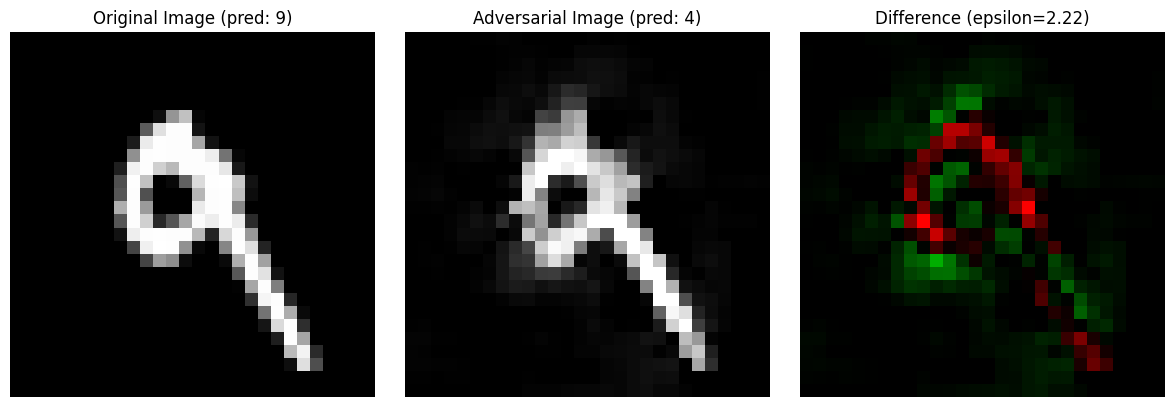

In [32]:
# Run FGM attack on the first batch
images, labels = next(iter(test_loader))
adv_images_lip_untargeted = fgm_attack_untargeted(lip_model, images, labels, epsilon=2.4)

idx = 7
plot_adversarial_examples(lip_model, images[idx], adv_images_lip_untargeted[idx])

**Exercise 3.3.2**

Find (approximately) the budget required to perturb the image

In [33]:
# Change epsilon budget to observe when the attack becomes successful

epsilons = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5]

for eps in epsilons:
    adv_images_lip_untargeted = fgm_attack_untargeted(lip_model, images, labels, epsilon=eps)

    adv_preds = lip_model(adv_images_lip_untargeted.to(device)).argmax(dim=1)
    diffs = torch.norm(images[idx].to(device) - adv_images_lip_untargeted[idx])

    if adv_preds[idx].item() != labels[idx].item():
        print(f"✅ Attack succeeded at epsilon = {diffs:.4f}  (set budget = {eps})")
    else:
        print(f"❌ Attack failed at epsilon = {diffs:.4f}  (set budget = {eps})")

    # plot_adversarial_examples(model, images[idx], adv_images_lip_untargeted[idx])

✅ Attack succeeded at epsilon = 1.4213  (set budget = 1.5)
✅ Attack succeeded at epsilon = 1.5125  (set budget = 1.6)
✅ Attack succeeded at epsilon = 1.6040  (set budget = 1.7)
✅ Attack succeeded at epsilon = 1.6942  (set budget = 1.8)
✅ Attack succeeded at epsilon = 1.7828  (set budget = 1.9)
✅ Attack succeeded at epsilon = 1.8710  (set budget = 2.0)
✅ Attack succeeded at epsilon = 1.9589  (set budget = 2.1)
✅ Attack succeeded at epsilon = 2.0468  (set budget = 2.2)
✅ Attack succeeded at epsilon = 2.1349  (set budget = 2.3)
✅ Attack succeeded at epsilon = 2.2231  (set budget = 2.4)
✅ Attack succeeded at epsilon = 2.3071  (set budget = 2.5)


**Exercise 3.3.3**

Run APGD attack on the LipNet

In [34]:
# Run APGD on LipCNN

apgd_attack_lip = APGD(
    lip_model,
    norm="L2",
    eps=2.2,
    n_restarts=5,
    verbose=True,
)

adv_images_apgd_lip = apgd_attack_lip(images, labels)
adv_images_apgd_lip = adv_images_apgd_lip.detach().cpu()

-------------------------- running L2-attack with epsilon 2.2000 --------------------------
initial accuracy: 100.00%
parameters:  10 2 1 1
iteration: 0 - Best loss: 178.380951
iteration: 1 - Best loss: 233.487244
iteration: 2 - Best loss: 243.690292
iteration: 3 - Best loss: 246.916977
iteration: 4 - Best loss: 247.628555
iteration: 5 - Best loss: 247.853058
iteration: 6 - Best loss: 248.070129
iteration: 7 - Best loss: 248.372864
iteration: 8 - Best loss: 248.692642
iteration: 9 - Best loss: 248.948090
restart 0 - robust accuracy: 46.88% - cum. time: 0.2 s
parameters:  10 2 1 1
iteration: 0 - Best loss: 74.359329
iteration: 1 - Best loss: 99.527802
iteration: 2 - Best loss: 103.859695
iteration: 3 - Best loss: 105.288071
iteration: 4 - Best loss: 105.750626
iteration: 5 - Best loss: 105.894592
iteration: 6 - Best loss: 105.996193
iteration: 7 - Best loss: 106.135147
iteration: 8 - Best loss: 106.276855
iteration: 9 - Best loss: 106.389175
restart 1 - robust accuracy: 45.31% - cum. ti

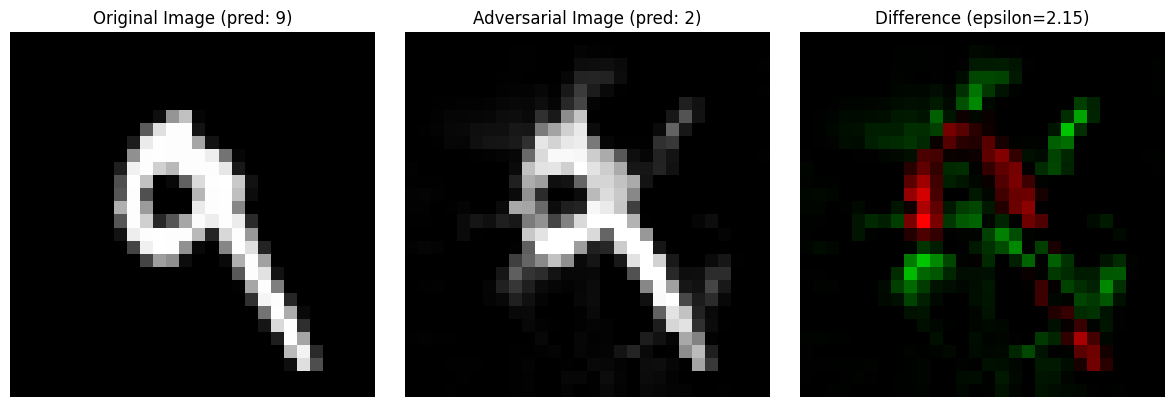

In [35]:
idx = 7
plot_adversarial_examples(lip_model, images[idx], adv_images_apgd_lip[idx])

**Exercise 3.3.4**

1. Compare the empirical budget epsilon and the robustness certificate.
2. Compare the empirical robustness between the standard and the Lipschitz network.

In [36]:
# Comparison between FGM and APGD on both standard and Lipschitz networks

epsilons = [1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7]

for eps in epsilons:
    apgd_attack_lip = APGD(
        lip_model,
        norm="L2",
        eps=eps,
        n_restarts=5,
        verbose=False,
    )

    images, labels = next(iter(test_loader))
    adv_images_apgd = apgd_attack_lip(images, labels)
    adv_images_apgd = adv_images_apgd.detach().cpu()

    adv_preds = model(adv_images_apgd.to(device)).argmax(dim=1)
    diffs = torch.norm(images[idx] - adv_images_apgd[idx])

    if adv_preds[idx].item() != labels[idx].item():
        print(f"✅ Attack succeeded at epsilon = {diffs:.4f}  (set budget = {eps})")
    else:
        print(f"❌ Attack failed at epsilon = {eps:.4f}  (set budget = {eps})")

❌ Attack failed at epsilon = 1.8000  (set budget = 1.8)
❌ Attack failed at epsilon = 1.9000  (set budget = 1.9)
❌ Attack failed at epsilon = 2.0000  (set budget = 2.0)
❌ Attack failed at epsilon = 2.1000  (set budget = 2.1)
❌ Attack failed at epsilon = 2.2000  (set budget = 2.2)
❌ Attack failed at epsilon = 2.3000  (set budget = 2.3)
❌ Attack failed at epsilon = 2.4000  (set budget = 2.4)
❌ Attack failed at epsilon = 2.5000  (set budget = 2.5)
❌ Attack failed at epsilon = 2.6000  (set budget = 2.6)
✅ Attack succeeded at epsilon = 2.6437  (set budget = 2.7)


### 3.4 Train and evaluate with different temperatures

You can re-run the sections 3.1 to 3.3 with a different temperature `tau`. We expect
that for smaller temperatures, the robustness of the LipNet is increased, with a small
drop in accuracy. The temperature is an important parameter to move on the Pareto
frontier of the accuracy-robustness curve.


**Exercise 3.4.1**

Complete the following code to train a new LipNet with a lower temperature.

In [37]:
lip_model_tau1 = LipCNN().to(device)

criterion = TauCrossEntropyLoss(tau=1)
optimizer = torch.optim.Adam(lip_model_tau1.parameters(), lr=LR)

train(lip_model_tau1, train_loader, val_loader, optimizer, criterion, device)

test_loss, test_acc = evaluate(lip_model_tau1, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Starting training...
Epoch [1/10] Train Loss: 0.8103, Train Acc: 0.8695 | Val Loss: 0.6781, Val Acc: 0.9165
Epoch [2/10] Train Loss: 0.6565, Train Acc: 0.9156 | Val Loss: 0.6347, Val Acc: 0.9240
Epoch [3/10] Train Loss: 0.6250, Train Acc: 0.9226 | Val Loss: 0.6143, Val Acc: 0.9298
Epoch [4/10] Train Loss: 0.6086, Train Acc: 0.9278 | Val Loss: 0.6013, Val Acc: 0.9307
Epoch [5/10] Train Loss: 0.5954, Train Acc: 0.9311 | Val Loss: 0.5866, Val Acc: 0.9357
Epoch [6/10] Train Loss: 0.5856, Train Acc: 0.9327 | Val Loss: 0.5826, Val Acc: 0.9328
Epoch [7/10] Train Loss: 0.5781, Train Acc: 0.9345 | Val Loss: 0.5736, Val Acc: 0.9378
Epoch [8/10] Train Loss: 0.5722, Train Acc: 0.9353 | Val Loss: 0.5667, Val Acc: 0.9385
Epoch [9/10] Train Loss: 0.5685, Train Acc: 0.9367 | Val Loss: 0.5614, Val Acc: 0.9332
Epoch [10/10] Train Loss: 0.5654, Train Acc: 0.9377 | Val Loss: 0.5608, Val Acc: 0.9388
Test Loss: 0.5496, Test Acc: 0.9412


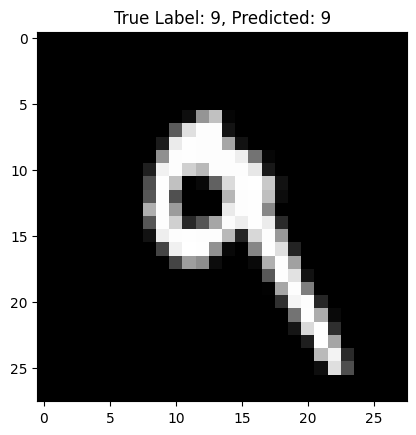

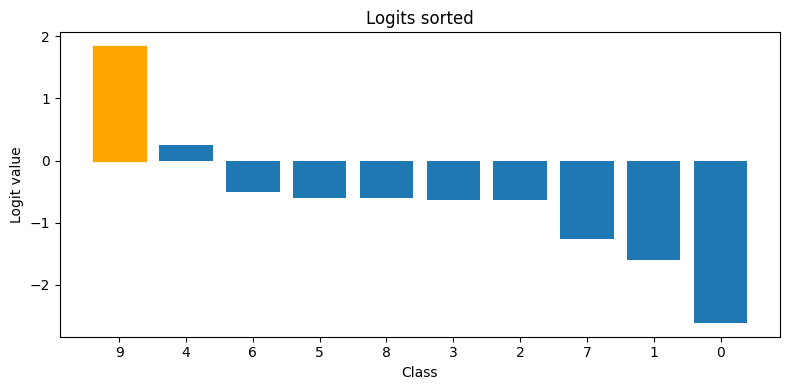

Certificates:
 tensor([2.0453, 1.6184, 2.1335, 1.1968, 1.1993, 2.1000, 1.0377, 1.1241, 0.3119,
        0.8966, 1.7676, 1.5163, 0.9991, 1.9878, 2.2072, 0.9169, 0.9291, 2.1551,
        0.7981, 1.2475, 1.0199, 1.5214, 0.6736, 1.4520, 0.7036, 2.4493, 1.1939,
        1.2061, 1.9350, 1.8472, 1.4962, 1.7254, 1.6533, 0.0228, 1.5085, 2.2370,
        2.0420, 2.0892, 0.4398, 1.6268, 1.9039, 1.0960, 1.2726, 0.7105, 0.6608,
        0.5616, 0.8219, 1.4293, 0.8941, 1.8252, 2.0410, 1.8560, 1.5267, 0.7468,
        1.6791, 0.9015, 2.2022, 2.2608, 1.0771, 0.8917, 1.6106, 0.5687, 0.3726,
        0.1068, 1.0684, 0.2008, 0.7576, 1.5191, 0.6315, 1.9587, 2.3386, 2.7936,
        1.1924, 0.0332, 1.9732, 1.1259, 1.1786, 0.1468, 0.5910, 1.6332, 0.5718,
        1.8251, 2.9054, 0.6559, 1.2446, 2.3971, 1.2930, 1.2263, 2.0360, 1.5804,
        1.5230, 2.2426, 0.0368, 1.5236, 1.0953, 0.8506, 1.1607, 0.4260, 0.8699,
        1.5185, 1.5980, 1.6179, 1.2836, 2.2552, 1.1591, 1.1400, 1.4479, 1.8770,
        1.2099, 1.0596, 0

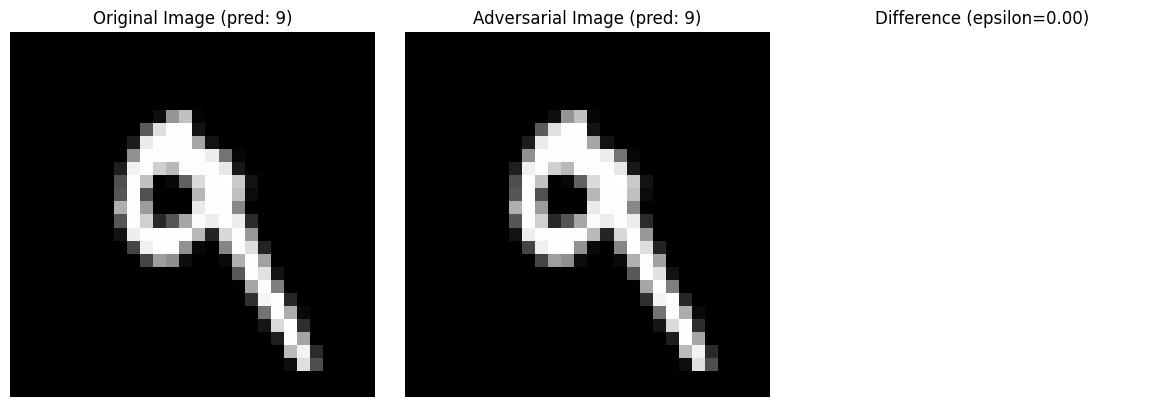

In [38]:
lip_model_tau1.eval()
with torch.no_grad():
    sample_images, sample_labels = next(iter(test_loader))
    sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)
    sample_logits = lip_model_tau1(sample_images)

# Plot a single image
idx = 7
plt.imshow(sample_images[idx].cpu().squeeze(), cmap="gray")
plt.title(f"True Label: {sample_labels[idx].item()}, Predicted: {sample_logits[idx].argmax().item()}")

# Plot sorted logits
plot_sorted_logits(sample_logits[idx], MNIST_CLASS_NAMES)

certificates, _ = compute_certificates(lip_model_tau1, images)
print("Certificates:\n", certificates)


# Run APGD on LipCNN
apgd_attack_lip = APGD(lip_model_tau1, norm="L2", eps=2.4, verbose=True)
adv_images_apgd_lip = apgd_attack_lip(images, labels)
adv_images_apgd_lip = adv_images_apgd_lip.detach().cpu()
idx = 7
plot_adversarial_examples(lip_model_tau1, images[idx], adv_images_apgd_lip[idx])

## 4. Certified Robust accuracy (CRA) on the test set

In this tutorial, we focus on the attack and robustness of a single image: we attacked
with a given budget and measured if it was succesful, and we computed the certificate of
an image (for LipNets).

Generally, we measure the performance of an attack or a defense on a whole test set. For
attacks, we measure the empirical robust accuracy at a given budget epsilon. In other
terms, we compute how many images of the test set can be misclassified by the attacker.

For LipNets, we can compute the Certified Robust Accuracy (CRA) which corresponds to the
percentage of certificates on the test set that are above a given budget epsilon. It
corresponds to a lower bound of the empirical robust accuracy measured by an adversarial
attack.

**Exercise 4.1**

1. Compute the empirical robust accuracy on the test set using the attack and the budget
   of your choice.
2. Compute the CRA on the test set for the same budget.

In [39]:
# Compute the certified robust accuracy


def certified_robust_accuracy(lip_model, epsilon, dataloader):
    """
    Computes the certified robust accuracy of a Lipschitz model on the given dataloader.

    Args:
        lip_model: the trained Lipschitz model
        epsilon: attack budget
        dataloader: DataLoader for evaluation

    Returns:
        acc: standard accuracy
        cert_acc: certified robust accuracy
    """
    lip_model.eval()
    correct = 0
    certified = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            certificates, preds = compute_certificates(lip_model, images)

            correct += (preds == labels).sum().item()
            certified += ((preds == labels) & (certificates > epsilon)).sum().item()
            total += images.size(0)

    acc = correct / total
    cert_acc = certified / total
    return acc, cert_acc

In [41]:
epsilon = 0.5
acc, cert_acc = certified_robust_accuracy(lip_model, epsilon, test_loader)

print("LipNet with tau=10")
print(f"- Test Accuracy: {acc:.4f}")
print(f"- Certified Robust Accuracy at epsilon={epsilon}: {cert_acc:.4f}")

acc, cert_acc = certified_robust_accuracy(lip_model_tau1, epsilon, test_loader)

print("LipNet with tau=1")
print(f"- Test Accuracy: {acc:.4f}")
print(f"- Certified Robust Accuracy at epsilon={epsilon}: {cert_acc:.4f}")

LipNet with tau=10
- Test Accuracy: 0.9892
- Certified Robust Accuracy at epsilon=0.5: 0.6528
LipNet with tau=1
- Test Accuracy: 0.9412
- Certified Robust Accuracy at epsilon=0.5: 0.8466
